In [1]:
%cd ..

/hdd/aouadt/these/projets/3d_segm


In [2]:
from enum import Enum
from importlib import reload
import random
from functools import reduce
from os.path import join
from time import time
import os
import pathlib

from tqdm import tqdm
import pandas as pd
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
import pytorch_lightning as pl
import skimage.morphology as morp
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from PIL import Image, ImageDraw
import torchviz
# import chart_studio.plotly as ply


from deep_morpho.datasets.mnist_dataset import MnistClassifDataset
import deep_morpho.models.softplus as sfp
import general.array_morphology as arm
import general.structuring_elements as selm
from general.nn.loss import DiceLoss
import deep_morpho.threshold_fn as threshold_fn
import deep_morpho.morp_operations as morpop
import deep_morpho.models.threshold_layer as threshold_layer
import deep_morpho.models.complementation_layer as complementation_layer
import deep_morpho.models.pconv as pconv
import deep_morpho.models.lightning_pconv as lpconv
import deep_morpho.models.bise as bise
import deep_morpho.models.lui as lui
import deep_morpho.models.bisel as bisel
import deep_morpho.models.cobise as cobise
import deep_morpho.models.dilation_sum_layer as dis
import deep_morpho.models.bimonn as bimonn
import deep_morpho.models as models
import deep_morpho.models.lightning_bise as lbise
import deep_morpho.models.lightning_cobise as lcobise
import deep_morpho.models.lightning_bimonn as lbimonn
import deep_morpho.datasets.generate_forms1 as gfo
import deep_morpho.datasets.generate_forms2 as gfo2
import deep_morpho.datasets.generate_forms3 as gfo3
import deep_morpho.datasets.axspa_roi_dataset as axd
import deep_morpho.datasets.diskorect_dataset as mrda
import deep_morpho.datasets.mnist_dataset as mnist_dataset
import deep_morpho.observables.plot_parameters as obs_weights
import deep_morpho.observables.plot_pred as obs_pred
import deep_morpho.observables.weight_histogram as weight_histogram
import deep_morpho.observables as obs
import general.nn.viz.plot_histogram as phist
import general.nn.viz.element_image as eltimage
import general.nn.viz.element_histogram as elthistogram
import deep_morpho.viz.morp_operations_viz as mov
import deep_morpho.viz.elt_generator_bimonn_forward_save as eltgenbifor
import deep_morpho.viz.elt_generator_bimonn_histogram as eltgenbihist
import deep_morpho.viz.bimonn_viz as bimonn_viz

def reload_modules():
    for modl in [sfp, arm, selm, threshold_fn, morpop,
                 threshold_layer,complementation_layer, pconv, lpconv, bise, lui, bisel, cobise,
                 dis, bimonn, models, lbise, lbimonn, lcobise, gfo, gfo2, gfo3, axd,
                 mrda, mnist_dataset, obs_weights, obs_pred, obs,
                weight_histogram, phist, eltimage, elthistogram, mov, eltgenbifor, eltgenbihist, bimonn_viz]:
        reload(modl)
        
reload_modules()

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

ModuleNotFoundError: No module named 'deep_morpho.models.cobise'

In [12]:
dest = "data/deep_morpho/binarization_selems"
dest_float = join(dest, "float_selems")
dest_binary = join(dest, "binary_selems")

metadata_path = join(dest, "metadata.csv")

In [13]:
class CertaintyEnum(Enum):
    NO_INFO = -1
    IS_ACTIVATED = 0
    NOT_ACTIVATED_BUT_CERTAIN = 1
    QUITE_CERTAIN = 2

class OperationEnum(Enum):
    DILATION = 'dilation'
    EROSION = 'erosion'

In [14]:
def add_to_database(
    float_selem: np.ndarray,
    binary_selem: np.ndarray,
    bias: float,
    operation: OperationEnum,
    is_generated: bool,
    metadata_path: str = metadata_path,
    certainty: CertaintyEnum = CertaintyEnum.NO_INFO,
    dest_float: str = dest_float,
    dest_binary: str = dest_binary
):
    """Add a couple (float, binary) to the database. Must give the bias. Saves the arrays and updates the metadata.

    Args:
        metadata_path (str): path to metadata that will be updated.
        float_selem (np.ndarray): array in float numbers
        binary_selem (np.ndarray): array in binary numbers
        bias (float): value of the bias
        operation (OperationEnum): dilation or erosion
        certainty (CertaintyEnum, optional): certainty description of the element. Use to classify the dataset and use it
                                                more easily.
        dest_float (str, optional): Destination folder for the float selem. Defaults to dest_float.
        dest_binary (str, optional): Destination folder for the binary selem. Defaults to dest_binary.
    """
    pathlib.Path(dest_float).mkdir(exist_ok=True, parents=True)
    pathlib.Path(dest_binary).mkdir(exist_ok=True, parents=True)

    float_path = join(dest_float, f'{len(os.listdir(dest_float))}.npy')
    binary_path = join(dest_binary, f'{len(os.listdir(dest_binary))}.npy')
    
    if not os.path.exists(metadata_path):
        df = pd.DataFrame()
        pathlib.Path(metadata_path).parent.mkdir(exist_ok=True, parents=True)
    else:
        df = pd.read_csv(metadata_path)

    row = pd.DataFrame({
        'float_selem_path': [float_path],
        'binary_selem_path': [binary_path],
        'operation': [operation.value],
        'bias': [bias],
        'certainty': [certainty],
        'is_generated': [is_generated],
    })
    
    df = pd.concat([df, row])

    np.save(float_path, float_selem)
    np.save(binary_path, binary_selem.astype(np.uint8))


    df.to_csv(metadata_path, index=False)
    print(f"Added to database:\nFloat: {float_path}\nBinary: {binary_path}")
    return df

# Add generated examples

In [4]:
reload_modules()
img = selm.hstick(7)

for _ in range(10):
    eps = np.random.rand()
    bias = np.random.rand() * eps

    img[3, -1] = eps
    selem = selm.hstick(7)
    if bias >= eps:
        selem[3, -1] = 0
    
    assert bise.BiSE.is_dilation_by(torch.tensor(img), -bias, selem.astype(bool)), _
    # add_to_database(img, selem, -bias, OperationEnum.DILATION, is_generated=True, certainty=CertaintyEnum.IS_ACTIVATED)

for _ in range(10):
    eps = np.random.rand()
    bias = np.random.rand() * (1 - eps) + eps

    img[3, -1] = eps
    selem = selm.hstick(7)
    if bias >= eps:
        selem[3, -1] = 0
    
    assert bise.BiSE.is_dilation_by(torch.tensor(img), -bias, selem.astype(bool)), _
    # add_to_database(img, selem, -bias, OperationEnum.DILATION, is_generated=True, certainty=CertaintyEnum.IS_ACTIVATED)



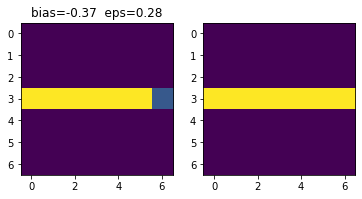

In [103]:
plt.subplot(121)
plt.imshow(img)
plt.title(f"bias={bias:.2f}  eps={eps:.2f}")

plt.subplot(122)
plt.imshow(selem)

# Add True encountered examples

[]

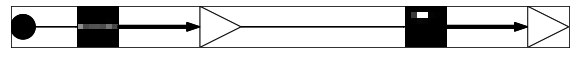

In [4]:
tb_path = "deep_morpho/results/results_tensorboards/Bimonn_exp_59/sandbox/0/softplus/diskorect/translation_erosion/hstick/version_0"
tb_path = join(tb_path, 'checkpoints', os.listdir(join(tb_path, 'checkpoints'))[0])

model = models.LightningBiMoNN.load_from_checkpoint(tb_path)
model.to(device)

fig_weights = bimonn_viz.BimonnVizualiser(model.model).get_fig(figsize=(10, 10), axis='on')
fig_weights.axes[0].set_xticks([])
fig_weights.axes[0].set_yticks([])

In [65]:
layer = model.model.layers[1].bise_0


In [68]:
weights_float = layer._normalized_weight.squeeze().cpu().detach().numpy()
# selem_binary = selm.hstick(7)
selem_binary = np.zeros_like(weights_float)
selem_binary[1, 2] = 1
bias = layer.bias.item()
operation = OperationEnum.EROSION
certainty = CertaintyEnum.QUITE_CERTAIN

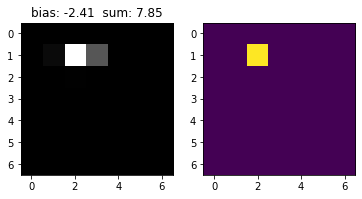

In [69]:
plt.subplot(121)
plt.imshow(weights_float, cmap='gray')
plt.title(f'bias: {bias:.2f}  sum: {weights_float.sum():.2f}')

plt.subplot(122)
plt.imshow(selem_binary)

In [70]:
df = add_to_database(float_selem=weights_float, binary_selem=selem_binary, bias=bias, operation=operation, certainty=certainty, is_generated=False)

Added to database:
Float: data/deep_morpho/binarization_selems/float_selems/3.npy
Binary: data/deep_morpho/binarization_selems/binary_selems/3.npy


In [86]:
df

,float_selem_path,binary_elem_path,operation,bias,certainty,is_generated
0,data/deep_morpho/binarization_selems/float_sel...,data/deep_morpho/binarization_selems/binary_se...,OperationEnum.DILATION,-2.335849,CertaintyEnum.QUITE_CERTAIN,False
1,data/deep_morpho/binarization_selems/float_sel...,data/deep_morpho/binarization_selems/binary_se...,OperationEnum.EROSION,-0.352507,CertaintyEnum.QUITE_CERTAIN,False
2,data/deep_morpho/binarization_selems/float_sel...,data/deep_morpho/binarization_selems/binary_se...,OperationEnum.EROSION,-2.576281,CertaintyEnum.QUITE_CERTAIN,False
3,data/deep_morpho/binarization_selems/float_sel...,data/deep_morpho/binarization_selems/binary_se...,OperationEnum.EROSION,-2.412501,CertaintyEnum.QUITE_CERTAIN,False


# Evaluate binarization techniques

In [15]:
df = pd.read_csv(metadata_path)

In [16]:
def read_row(row):
    float_img = np.load(row['float_selem_path'])
    binary_img = np.load(row['binary_selem_path'])
    operation = row['operation']
    bias = row['bias']

    return float_img, binary_img, operation, bias

In [17]:
def find_closest(weights, bias, closest_selem_distance_fn=bise.ClosestSelemDistanceEnum.DISTANCE_TO_BOUNDS):
    return bise.BiSE.find_closest_selem_and_operation_chan_static(
        weights=torch.FloatTensor(weights).unsqueeze(0).unsqueeze(0), bias=torch.FloatTensor([bias]), idx=0,
        closest_selem_distance_fn=closest_selem_distance_fn 
        )



In [24]:
reload_modules()
is_ok = []
is_operation_ok = []
is_selem_ok = []

selem_preds = []
selem_trues = []
float_imgs = []

for row_idx, row in df.iterrows():
# for row_idx, row in df[df['certainty'] == 'CertaintyEnum.QUITE_CERTAIN'].iterrows():
    float_img, selem_true, operation_true, bias = read_row(row)
    final_dist, selem_pred, operation_pred = find_closest(
        float_img,
        bias,
        bise.ClosestSelemDistanceEnum.DISTANCE_TO_BOUNDS
        # bise.ClosestSelemDistanceEnum.DISTANCE_BETWEEN_BOUNDS
        # bise.ClosestSelemDistanceEnum.DISTANCE_TO_AND_BETWEEN_BOUNDS
    )

    selem_preds.append(selem_pred)
    selem_trues.append(selem_true)
    float_imgs.append(float_img)
    is_operation_ok.append(operation_pred in operation_true)
    is_selem_ok.append(np.abs(selem_true - selem_pred).sum() == 0)

    is_ok.append((np.abs(selem_true - selem_pred).sum() == 0) & (operation_pred in operation_true))

df['all_ok'] = is_ok
df['operation_ok'] = is_operation_ok
df['selem_ok'] = is_selem_ok

print("All ok:", np.mean(is_ok))
print("Operation ok", np.mean(is_operation_ok))
print("Selem ok", np.mean(is_selem_ok))
df.groupby('certainty')[['all_ok', 'operation_ok', 'selem_ok']].mean()


All ok: 0.9166666666666666
Operation ok 1.0
Selem ok 0.9166666666666666


,all_ok,operation_ok,selem_ok
certainty,,,
CertaintyEnum.IS_ACTIVATED,1.0,1.0,1.0
CertaintyEnum.QUITE_CERTAIN,0.5,1.0,0.5


In [27]:
img, selem, _, _ = read_row(df.iloc[0])

In [ ]:
plt.subplot(121)
plt.imshow(img, cmap='gray')

